# Time-Dependent Variational Principle (TDVP)

Here we will simulate the real-time evolution of quantum states in one-dimensional spin systems driven by time-independent Hamiltonians by using 1-site time-dependent variational principle (TDVP).

In order to do so we will consider the XY spin-1/2 chain. We will start with a chain of length N such that, at time t=0, the left part is up-polarized while the right part is down-polarized:

\begin{equation}
|\Psi(t=0)> = |\uparrow>_1|\uparrow>_1\cdots|\uparrow>_{N/2-1}|\uparrow>_{N/2}|\downarrow>_{N/2+1}|\downarrow>_{N/2+2}\cdots|\downarrow>_{N-1}|\downarrow>_{N}
\end{equation}

In such a way we are creating a domain wall in between sites N/2 and N/2 + 1.

After that, we will let the system evolve in time via $\exp{-i\hat{H}_{X}t}$: the domain wall wil be blurred out and spread. In the limit of $N\rightarrow\infty$, the exact solution of the magnetization is:

\begin{equation}
<\Psi(t)|\hat{S}_l^z|\Psi(t)> =-\frac{1}{2}\sum_{n=1-(l-N/2)}^{(l-N/2)-1}[J_n(t)]^2\quad\text{ for } j>N/2
\end{equation}

with $<\Psi(t)|\hat{S}_l^z|\Psi(t)>=-<\Psi(t)|\hat{S}_{N-l}^z|\Psi(t)>$ and $J_n(t)$ is the Bessel function of the first kind [D. Gobert et al, Phys. Rev. E 71, 036102 (2005)].

First of all we will compute $<\Psi(t)|\hat{S}_l^z|\Psi(t)>$ and then we will compare it with the exact result:

In [1]:
# Load all relevant modules
include("../JTensorNetwork.jl");
using PyPlot

In [2]:
# System parameters
J = +1; # Coupling strength
N = 50; # Number of sites in a chain

# DMRG parameters
Nkeep = 20;  # Bond dimension
dt = 1/20;   # discrete time step size
tmax = 20;   # maximum time

# Local operators
S,Id = getLocalSpace("Spin",1/2);

# XY Model in MPO form
Hloc = MPO_XY(J);
Hs = Vector{Any}(undef, N);
for i in 1:N
    Hs[i] = Hloc[:,:,:,:];
end
Hs[1] = reshape(Hs[1][end,:,:,:],(1,2,4,2));   # last components of the left leg
Hs[end] = reshape(Hs[end][:,:,1,:],(4,2,1,2)); # first components of the right leg

# Operator to measure magnetization
Sz = S[:,3,:];

# MPS initialization
M = Vector{Union{Array{ComplexF64,3},Array{Float64,3}}}(undef, N);
M[1] = zeros(1,size(Id,2),Nkeep);
for i in 2:(N-1)
    M[i] =  zeros(Nkeep,size(Id,2),Nkeep);
end
M[N] = zeros(Nkeep,size(Id,2),1);
for itN = (1:N)
    if itN <= N/2
        M[itN][1,1,1] = 1;
    else
        M[itN][1,2,1] = 1;
    end
end

# 1-site TDVP
ts,M,Ovals,EE = TDVP_1site(M,Hs,Sz,Nkeep,dt,tmax);

1-site TDVP : Real-time evolution with local measurements
N = 50, Nkeep = 20, dt = 0.05, tmax = 20.0 ( 400 steps)
Time evolution: start
2/12/2020 8:39:6 (GMT) | # 40/400 : t = 2.0/20.0
2/12/2020 8:43:22 (GMT) | # 80/400 : t = 4.0/20.0
2/12/2020 8:47:26 (GMT) | # 120/400 : t = 6.0/20.0
2/12/2020 8:51:16 (GMT) | # 160/400 : t = 8.0/20.0
2/12/2020 8:55:7 (GMT) | # 200/400 : t = 10.0/20.0
2/12/2020 8:58:59 (GMT) | # 240/400 : t = 12.0/20.0
2/12/2020 9:2:46 (GMT) | # 280/400 : t = 14.0/20.0
2/12/2020 9:6:37 (GMT) | # 320/400 : t = 16.0/20.0
2/12/2020 9:10:9 (GMT) | # 360/400 : t = 18.0/20.0
2/12/2020 9:13:36 (GMT) | # 400/400 : t = 20.0/20.0
Elapsed time: 2364.4147238731384 s.


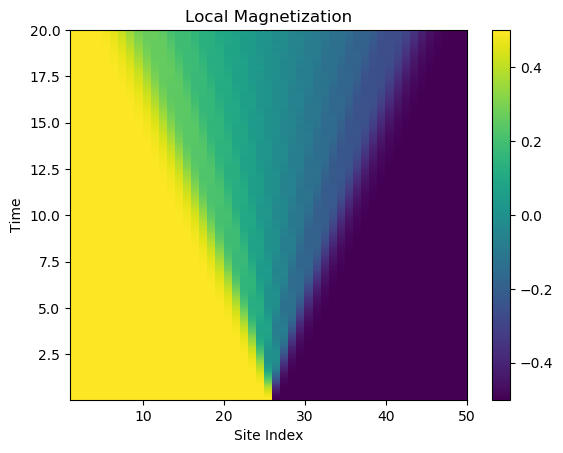

In [3]:
title("Local Magnetization");
xlabel("Site Index");
ylabel("Time");
pcolormesh(1:N,ts,real(Ovals));
colorbar();

Let's plot the error against the exact result, and the entanglement entropy. Note that this is the one-site update algorithm, so the discarded weights are trivially zero: it does not mean that it does not suffer with entanglement growth with time. Indeed, it is worse, since one cannot dynamically change the bond dimension in response to the entanglement growth. This problem can be remedied by considering the two-site TDVP [J. Haegeman, C. Lubich, I. Oseledets, B. Vandereycken, and F. Verstraete, Phys. Rev. B 94, 165116 (2016)].

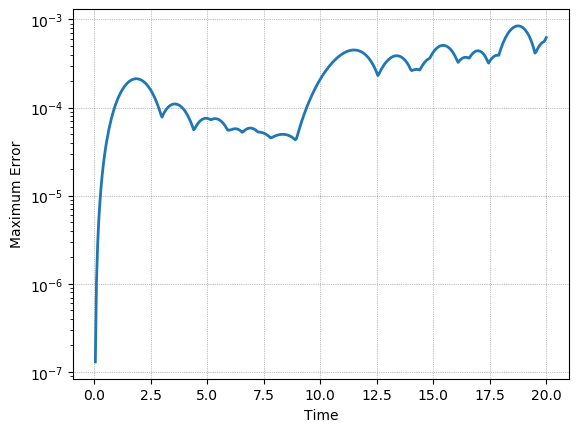

In [4]:
# exact values of magnetization in the infinite chain limit
# D. Gobert et al., Phys. Rev. E 71, 036102 (2005), Eq. (4)

# Bessel function of the 1st kind
using SpecialFunctions
fvals = zeros(length(ts),N-1);
for it in 1:size(fvals,2)
    for ij in 1:length(ts)
        fvals[ij,it] = (besselj(Int(it-N/2),ts[ij])).^2;
    end
end
fvals = -0.5*fvals;

# Exact values
Oexact = zeros(length(ts),Int(N/2));
for it in 1:Int(N/2)
    Oexact[:,it] = sum(fvals[:,Int(N/2-it+1):Int(it+N/2-1)],dims=2);
end
Oexact = hcat(-reverse(Oexact,dims=2),Oexact);

Oerr = maximum(abs.(Ovals-Oexact),dims=2);

ylabel("Maximum Error");
xlabel("Time");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(ts,Oerr,linewidth=2.0);

The error is comparable with that of the two-site tDMRG

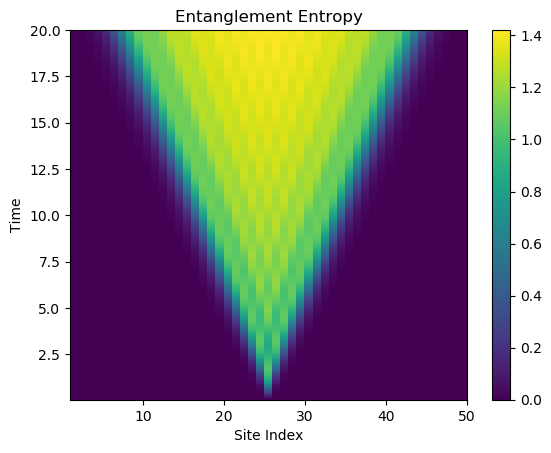

In [6]:
title("Entanglement Entropy");
xlabel("Site Index");
ylabel("Time");
pcolormesh(1:N,ts,EE[2:2:end,:]);
colorbar();